A jelenlegi verzió egy 0.67651-as AUC score-t produkál a Kaggle-s public leaderboard-on.

A submission fájl 2024-12-05 23:31-kor lett feltöltve a Kaggle-re "stable.csv" néven.

A megoldást szaktársammal, Varsányi Mátéval (IPBZX7) készítettük el.

# Data Analysis

In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import pandas as pd
import numpy as np


In [2]:
df = pd.read_csv('_data/public_data.csv')
print(df.head())


   rowID  season  periodID  day_in_period  hour  minute  holyday  weekday  \
0      0       1        18              0     0       0    False        2   
1      1       1        18              0     0      15    False        2   
2      2       1        18              0     0      30    False        2   
3      3       1        18              0     0      45    False        2   
4      4       1        18              0     1       0    False        2   

           ke      hupx  afrr_fel     afrr_le  mfrr_fel  mfrr_le        afrr  \
0  899.343121  287.7194    0.0000 -103.196933       0.0      0.0 -212.845947   
1  899.374587  287.7194   55.9286   -5.617200       0.0      0.0  263.427160   
2  899.303875  287.7194   69.6826   -9.355800       0.0      0.0  273.927320   
3  899.299787  287.7194   30.2718  -16.943567       0.0      0.0  132.621040   
4  897.436947  283.6309   25.9714  -12.064167       0.0      0.0  151.888080   

   solar_becsult_dayahead  rendszerterheles_terv  target

In [3]:
df.shape

(89760, 19)

In [4]:
df.columns

Index(['rowID', 'season', 'periodID', 'day_in_period', 'hour', 'minute',
       'holyday', 'weekday', 'ke', 'hupx', 'afrr_fel', 'afrr_le', 'mfrr_fel',
       'mfrr_le', 'afrr', 'solar_becsult_dayahead', 'rendszerterheles_terv',
       'target_flag', 'target_reg'],
      dtype='object')

In [5]:
df.dtypes

rowID                       int64
season                      int64
periodID                    int64
day_in_period               int64
hour                        int64
minute                      int64
holyday                      bool
weekday                     int64
ke                        float64
hupx                      float64
afrr_fel                  float64
afrr_le                   float64
mfrr_fel                  float64
mfrr_le                   float64
afrr                      float64
solar_becsult_dayahead    float64
rendszerterheles_terv     float64
target_flag               float64
target_reg                float64
dtype: object

In [6]:
missing_values = df.isnull().sum()
missing_percentages = (missing_values / len(df)) * 100
missing_info = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage': missing_percentages
})
print(missing_info[missing_info['Missing Values'] > 0])

             Missing Values  Percentage
ke                    17952        20.0
hupx                  17952        20.0
afrr_fel              17952        20.0
afrr_le               17952        20.0
mfrr_fel              17952        20.0
mfrr_le               17952        20.0
afrr                  17952        20.0
target_flag           17952        20.0
target_reg            17952        20.0


Ami teljesen okes mert ezek alapján csak a pénteki adatok hiányoznak.

In [7]:
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
print(df[numerical_cols].describe())

              rowID        season      periodID  day_in_period          hour  \
count  89760.000000  89760.000000  89760.000000   89760.000000  89760.000000   
mean   46909.416578      5.897326     96.529412       2.000000     11.500000   
std    26663.473071      3.047264     56.315251       1.414221      6.922225   
min        0.000000      1.000000      0.000000       0.000000      0.000000   
25%    24175.750000      3.000000     48.000000       1.000000      5.750000   
50%    46615.500000      6.000000     96.000000       2.000000     11.500000   
75%    69963.250000      9.000000    145.000000       3.000000     17.250000   
max    93264.000000     11.000000    194.000000       4.000000     23.000000   

             minute       weekday            ke          hupx      afrr_fel  \
count  89760.000000  89760.000000  71808.000000  71808.000000  71808.000000   
mean      22.500000      3.004278    851.362651    295.273332     59.974674   
std       16.770603      2.003746    116.9

In [8]:
categorical_cols = df.select_dtypes(include=['object', 'bool']).columns
for col in categorical_cols:
    print(f"\nValue counts for {col}:")
    print(df[col].value_counts())
    print(f"Unique values: {df[col].nunique()}")


Value counts for holyday:
holyday
False    86496
True      3264
Name: count, dtype: int64
Unique values: 2


In [9]:
time_features = ['season', 'periodID', 'day_in_period', 'hour', 'minute']
for feature in time_features:
    if feature in df.columns:
        print(f"\nDistribution of {feature}:")
        print(df[feature].value_counts().sort_index().head())


Distribution of season:
season
1    7200
2    8736
3    8352
4    8832
5    8640
Name: count, dtype: int64

Distribution of periodID:
periodID
0    480
1    480
2    480
3    480
4    480
Name: count, dtype: int64

Distribution of day_in_period:
day_in_period
0    17952
1    17952
2    17952
3    17952
4    17952
Name: count, dtype: int64

Distribution of hour:
hour
0    3740
1    3740
2    3740
3    3740
4    3740
Name: count, dtype: int64

Distribution of minute:
minute
0     22440
15    22440
30    22440
45    22440
Name: count, dtype: int64


In [10]:
correlation_matrix = df[numerical_cols].corr()
threshold = 0.7
high_corr_features = np.where(np.abs(correlation_matrix) > threshold)
high_corr_features = [(correlation_matrix.index[x], correlation_matrix.columns[y], correlation_matrix.iloc[x, y])
                     for x, y in zip(*high_corr_features) if x != y and x < y]

if high_corr_features:
    print("\nHighly correlated features (|correlation| > 0.7):")
    for feat1, feat2, corr in high_corr_features:
        print(f"{feat1} -- {feat2}: {corr:.3f}")


Highly correlated features (|correlation| > 0.7):
rowID -- season: 0.996
ke -- target_reg: -0.816
afrr_fel -- afrr: 0.925
target_flag -- target_reg: 0.720


In [11]:
for col in numerical_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = ((df[col] < (Q1 - 1.5 * IQR)) | (df[col] > (Q3 + 1.5 * IQR))).sum()
    if outliers > 0:
        print(f"{col}: {outliers} outliers detected ({(outliers/len(df)*100):.2f}% of data)")

ke: 4436 outliers detected (4.94% of data)
hupx: 9276 outliers detected (10.33% of data)
afrr_fel: 9807 outliers detected (10.93% of data)
afrr_le: 4439 outliers detected (4.95% of data)
mfrr_fel: 759 outliers detected (0.85% of data)
mfrr_le: 1220 outliers detected (1.36% of data)
afrr: 3510 outliers detected (3.91% of data)
rendszerterheles_terv: 16 outliers detected (0.02% of data)
target_reg: 4681 outliers detected (5.22% of data)


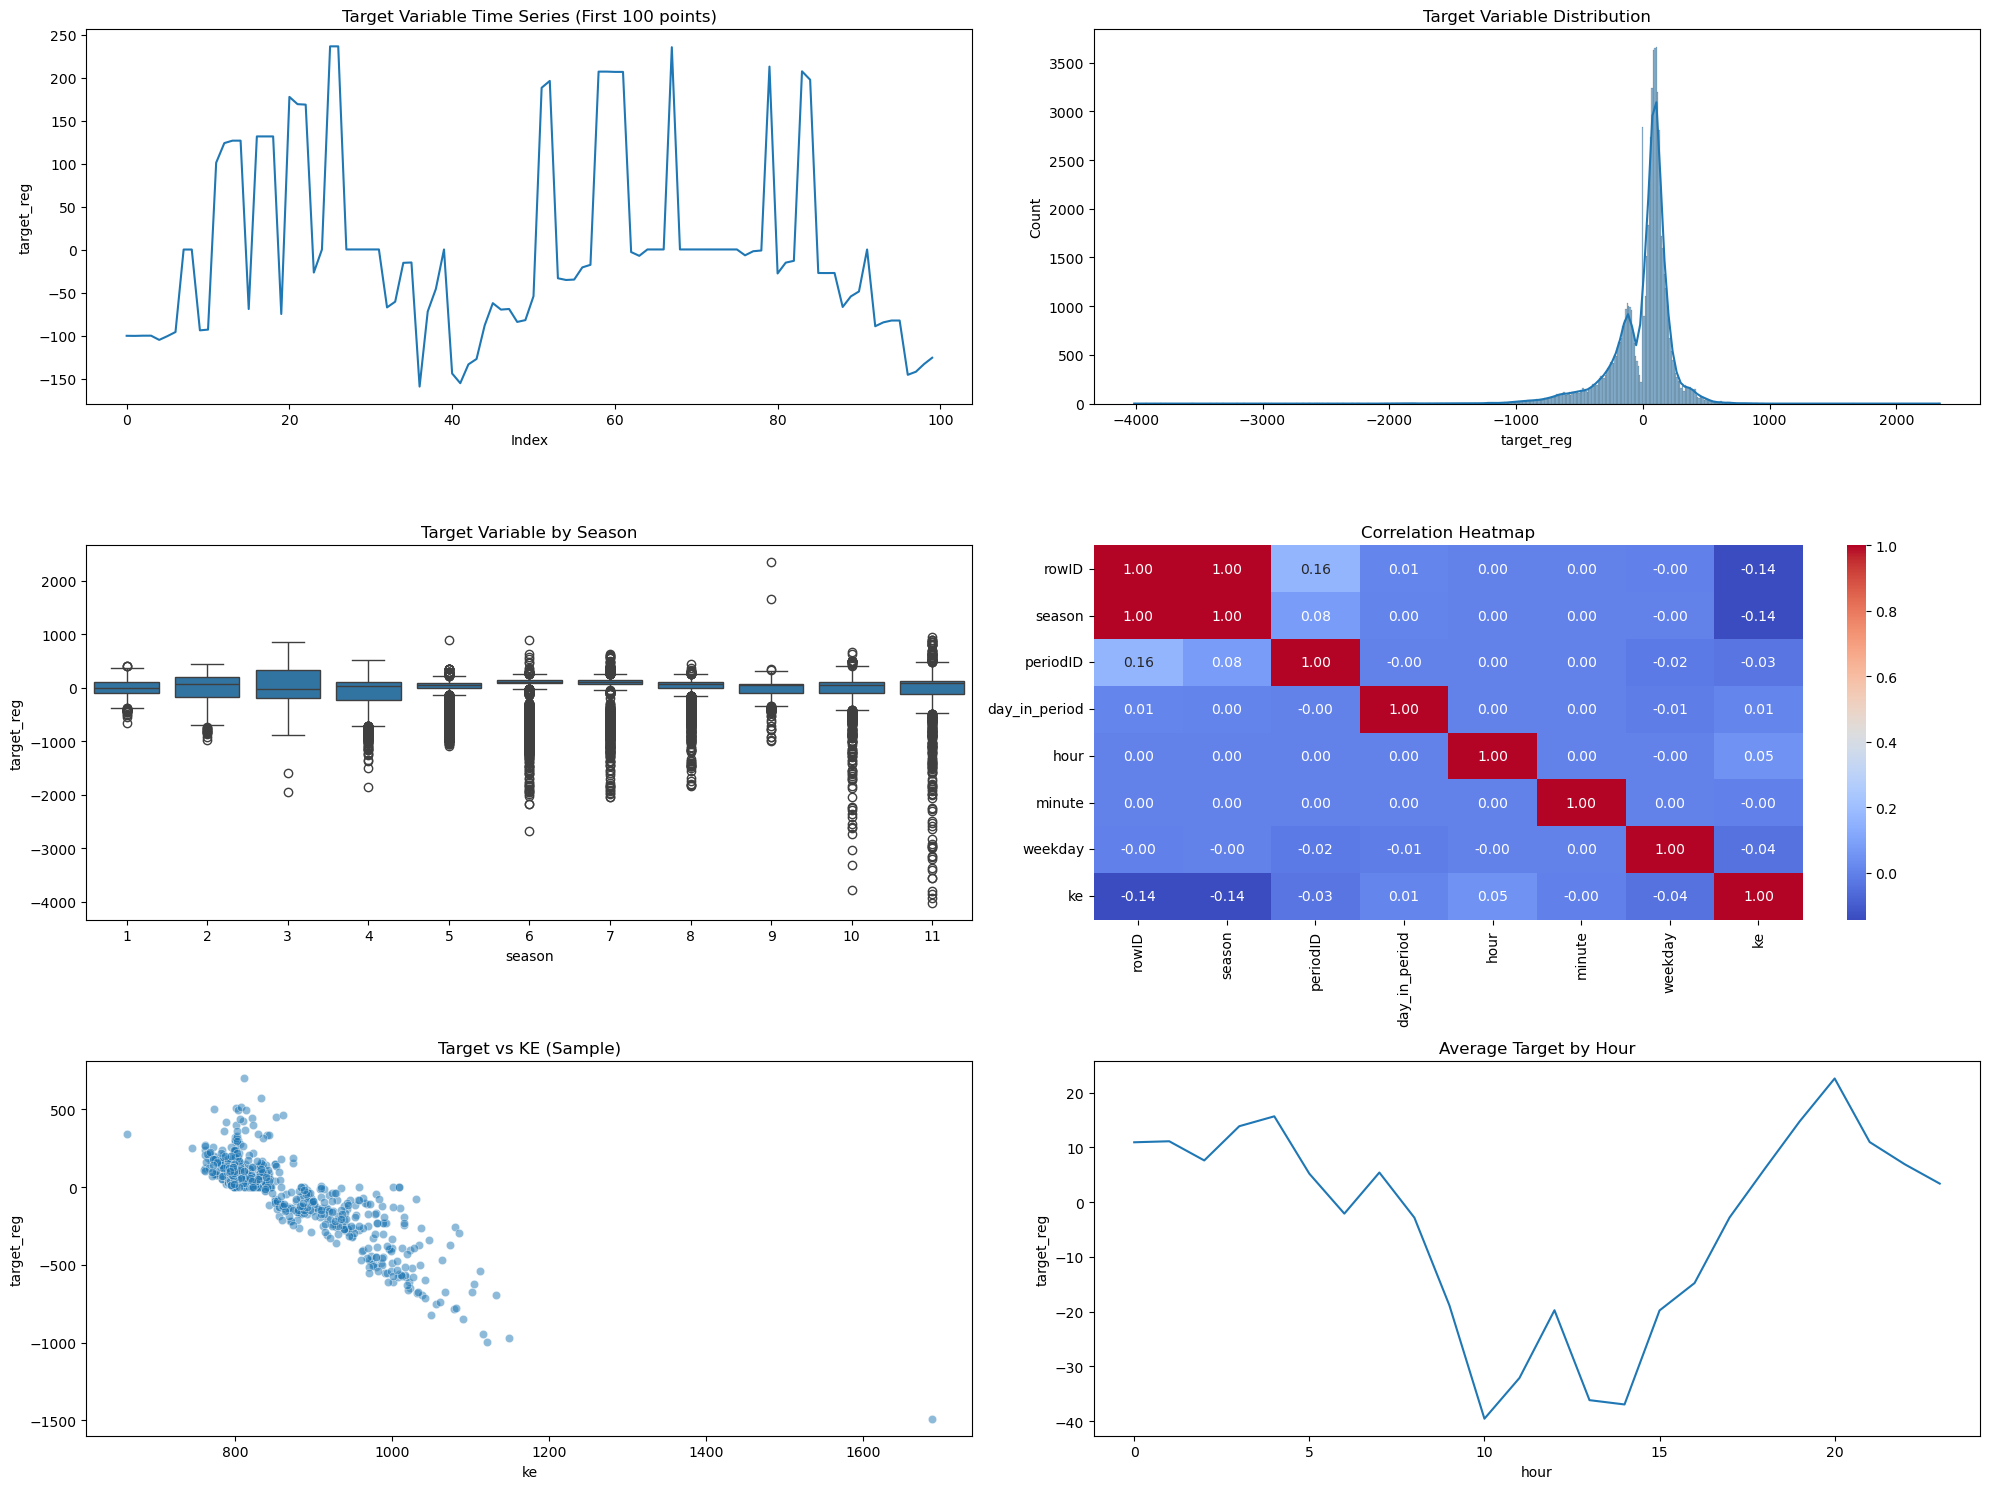

In [12]:
plt.figure(figsize=(20, 15))

plt.subplot(3, 2, 1)
plt.plot(df.index[:100], df['target_reg'][:100])
plt.title('Target Variable Time Series (First 100 points)')
plt.xlabel('Index')
plt.ylabel('target_reg')

plt.subplot(3, 2, 2)
sns.histplot(df['target_reg'], kde=True)
plt.title('Target Variable Distribution')

plt.subplot(3, 2, 3)
sns.boxplot(x='season', y='target_reg', data=df)
plt.title('Target Variable by Season')

plt.subplot(3, 2, 4)
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns[:8]
sns.heatmap(df[numerical_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')

plt.subplot(3, 2, 5)
sns.scatterplot(data=df.sample(1000), x='ke', y='target_reg', alpha=0.5)
plt.title('Target vs KE (Sample)')

plt.subplot(3, 2, 6)
sns.lineplot(data=df, x='hour', y='target_reg', errorbar=None)
plt.title('Average Target by Hour')

plt.tight_layout()
plt.show()

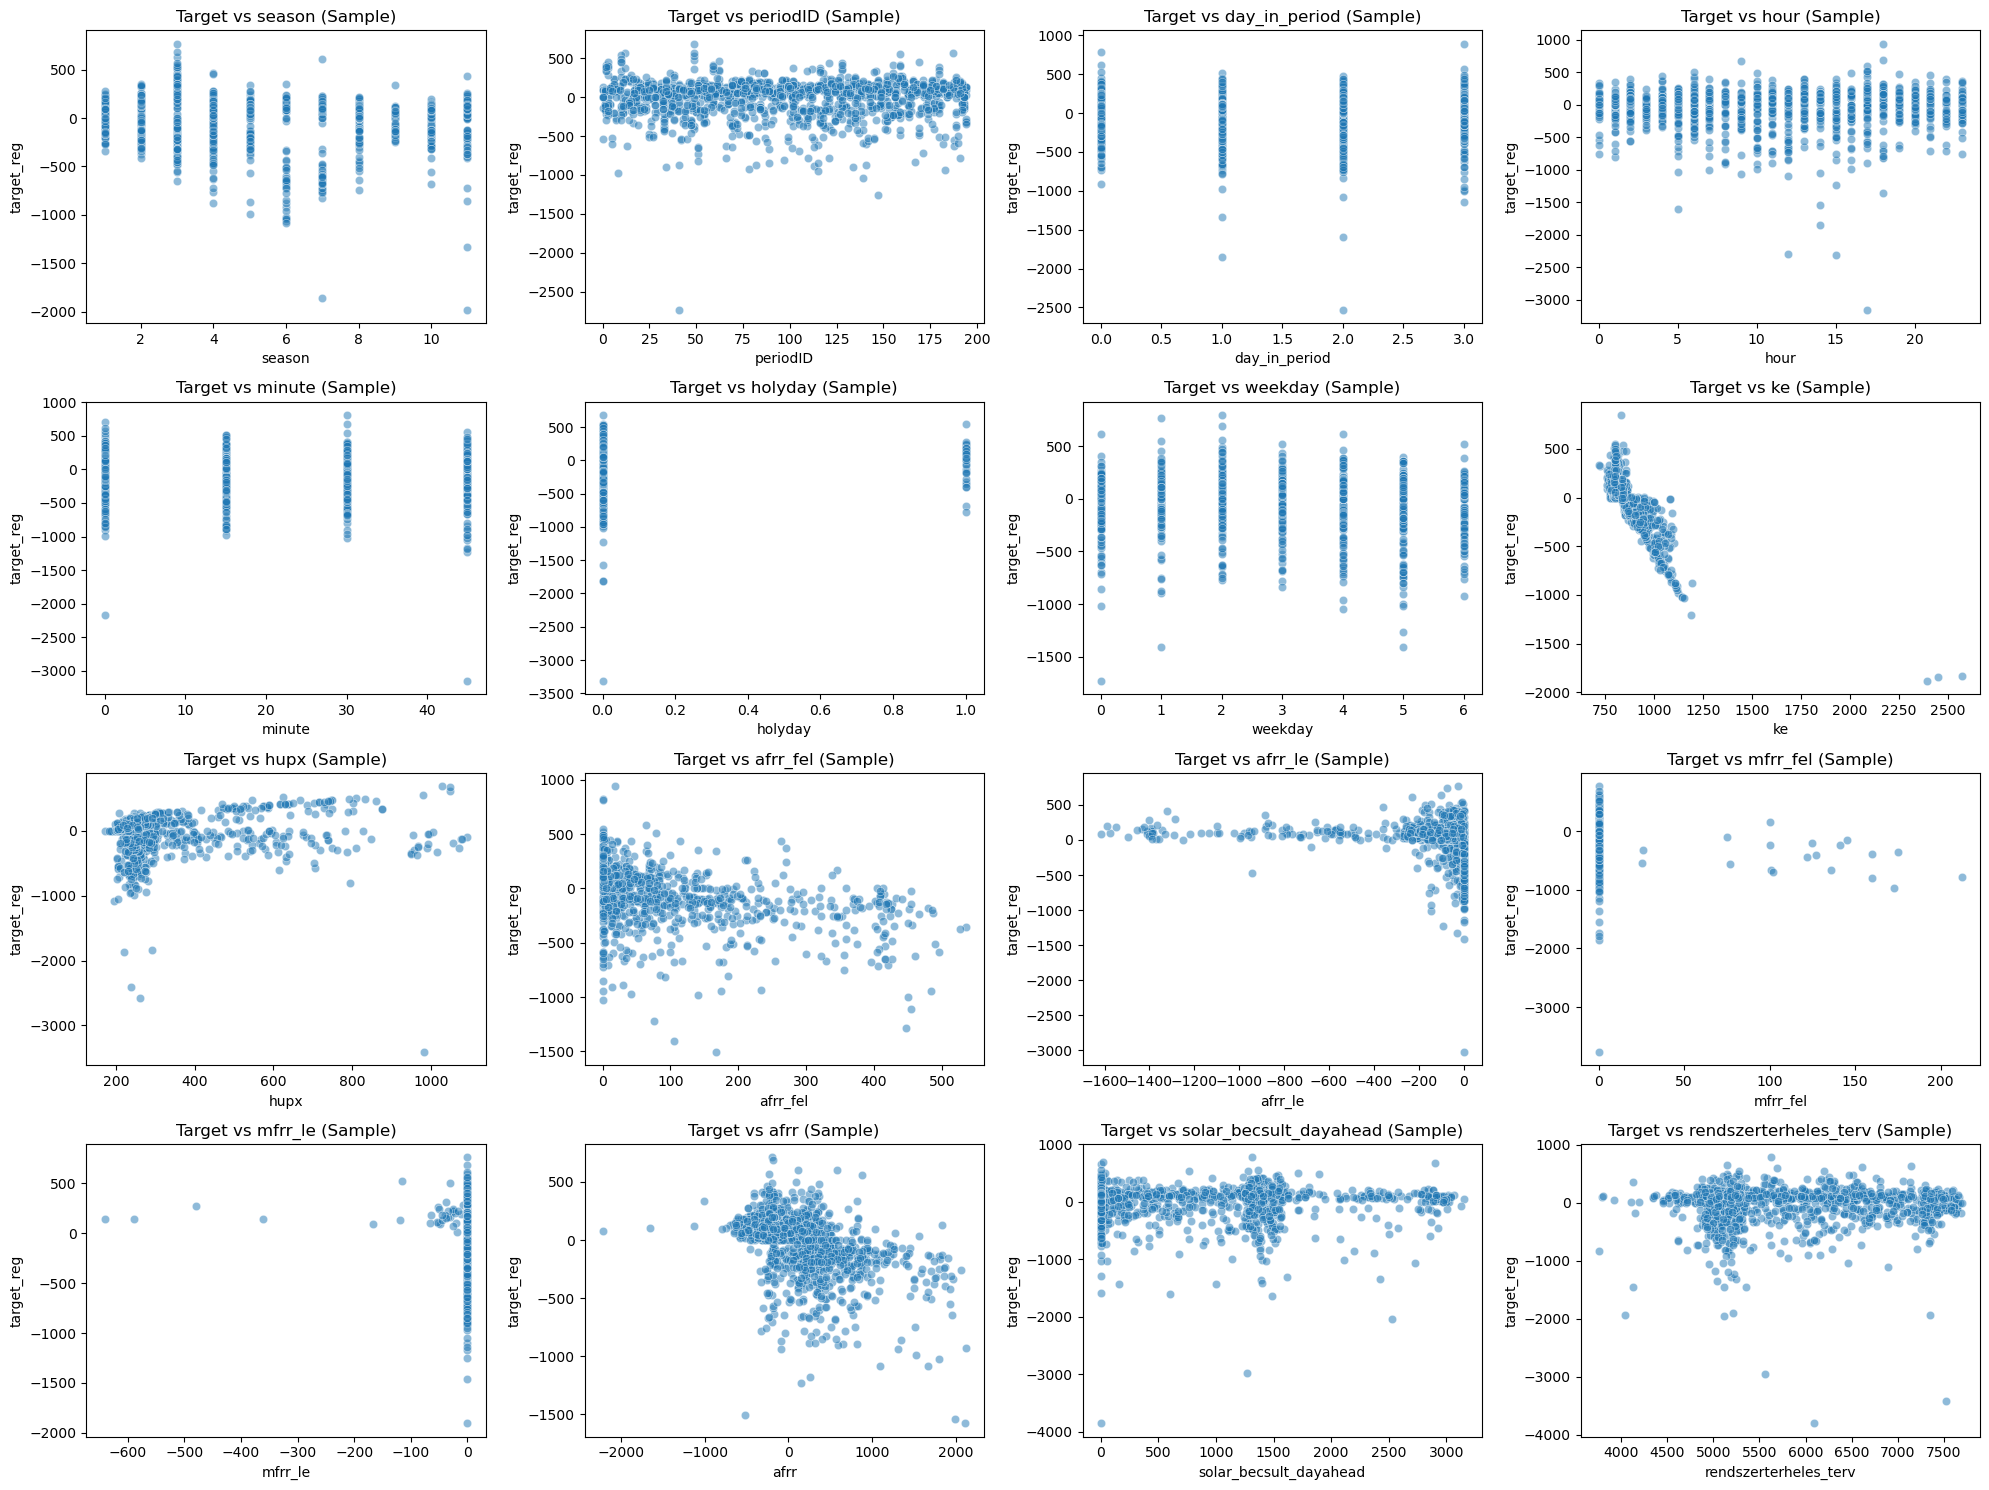

In [ ]:
plt.figure(figsize=(20, 15))

variables = ['season', 'periodID', 'day_in_period', 'hour', 'minute', 'holyday',
            'weekday', 'ke', 'hupx', 'afrr_fel', 'afrr_le', 'mfrr_fel',
            'mfrr_le', 'afrr', 'solar_becsult_dayahead', 'rendszerterheles_terv']

n_vars = len(variables)
n_cols = 4
n_rows = (n_vars + n_cols - 1) // n_cols

for idx, var in enumerate(variables, 1):
    plt.subplot(n_rows, n_cols, idx)
    sns.scatterplot(data=df.sample(2000), x=var, y='target_reg', alpha=0.5)
    plt.title(f'Target vs {var} (Sample)')
    plt.xlabel(var)
    plt.ylabel('target_reg')

plt.tight_layout()
plt.show()

# Data Preparation

In [15]:
def create_features(df):
    df['hour_sin'] = np.sin(2 * np.pi * df['hour']/24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour']/24)
    df['minute_sin'] = np.sin(2 * np.pi * df['minute']/60)
    df['minute_cos'] = np.cos(2 * np.pi * df['minute']/60)

    for window in [4, 8, 12]:
        df[f'rolling_solar_mean_{window}'] = df.groupby('periodID')['solar_becsult_dayahead'].transform(
            lambda x: x.rolling(window=window, min_periods=1).mean())
        df[f'rolling_load_mean_{window}'] = df.groupby('periodID')['rendszerterheles_terv'].transform(
            lambda x: x.rolling(window=window, min_periods=1).mean())

        df[f'rolling_solar_std_{window}'] = df.groupby('periodID')['solar_becsult_dayahead'].transform(
            lambda x: x.rolling(window=window, min_periods=1).std())
        df[f'rolling_load_std_{window}'] = df.groupby('periodID')['rendszerterheles_terv'].transform(
            lambda x: x.rolling(window=window, min_periods=1).std())

    for alpha in [0.3, 0.5, 0.7]:
        df[f'solar_ema_{alpha}'] = df.groupby('periodID')['solar_becsult_dayahead'].transform(
            lambda x: x.ewm(alpha=alpha, adjust=False).mean())
        df[f'load_ema_{alpha}'] = df.groupby('periodID')['rendszerterheles_terv'].transform(
            lambda x: x.ewm(alpha=alpha, adjust=False).mean())

    for lag in [1, 2]:
        df[f'solar_lag_{lag}'] = df.groupby('periodID')['solar_becsult_dayahead'].shift(lag)
        df[f'load_lag_{lag}'] = df.groupby('periodID')['rendszerterheles_terv'].shift(lag)

        df[f'solar_lag_diff_{lag}'] = df['solar_becsult_dayahead'] - df[f'solar_lag_{lag}']
        df[f'load_lag_diff_{lag}'] = df['rendszerterheles_terv'] - df[f'load_lag_{lag}']
        df[f'solar_lag_ratio_{lag}'] = df['solar_becsult_dayahead'] / (df[f'solar_lag_{lag}'] + 1)
        df[f'load_lag_ratio_{lag}'] = df['rendszerterheles_terv'] / (df[f'load_lag_{lag}'] + 1)

    def smooth_target_mean(group, alpha=5):
        counts = group.size
        means = group.mean()
        global_mean = means.mean()
        return (means * counts + global_mean * alpha) / (counts + alpha)

    for group_cols in [
        ['season', 'hour'],
        ['weekday', 'hour'],
        ['season', 'weekday']
    ]:
        name = '_'.join(group_cols)
        agg = df.groupby(group_cols)['target_flag'].agg(['mean', 'std']).reset_index()
        agg['smoothed_mean'] = smooth_target_mean(agg['mean'])
        df[f'target_mean_{name}'] = df[group_cols].merge(
            agg[group_cols + ['smoothed_mean']],
            on=group_cols,
            how='left'
        )['smoothed_mean']

        if agg['std'].notna().any():
            df[f'target_std_{name}'] = df[group_cols].merge(
                agg[group_cols + ['std']],
                on=group_cols,
                how='left'
            )['std']

    df['solar_load_ratio'] = df['solar_becsult_dayahead'] / (df['rendszerterheles_terv'] + 1)
    df['weekend'] = df['weekday'].isin([5, 6]).astype(int)

    df['solar_hour'] = df['solar_becsult_dayahead'] * np.sin(2 * np.pi * df['hour']/24)
    df['load_hour'] = df['rendszerterheles_terv'] * np.sin(2 * np.pi * df['hour']/24)
    df['solar_season'] = df['solar_becsult_dayahead'] * df['season']
    df['load_season'] = df['rendszerterheles_terv'] * df['season']

    df['load_ratio_hour'] = df['load_lag_ratio_1'] * df['hour_sin']
    df['solar_ratio_hour'] = df['solar_lag_ratio_1'] * df['hour_sin']
    df['load_ratio_season'] = df['load_lag_ratio_1'] * df['season']
    df['solar_ratio_season'] = df['solar_lag_ratio_1'] * df['season']

    return df

df = create_features(df)

In [17]:
df_filtered = df[df['day_in_period'] < 4]
df_filtered = df_filtered.fillna(method='ffill').fillna(method='bfill')

features = [
    'hour_sin', 'hour_cos', 'minute_sin', 'minute_cos',
    'holyday', 'weekday', 'weekend',

    'solar_becsult_dayahead', 'rendszerterheles_terv',

    'rolling_solar_mean_4', 'rolling_solar_mean_8', 'rolling_solar_mean_12',
    'rolling_load_mean_4', 'rolling_load_mean_8', 'rolling_load_mean_12',
    'rolling_solar_std_4', 'rolling_solar_std_8', 'rolling_solar_std_12',
    'rolling_load_std_4', 'rolling_load_std_8', 'rolling_load_std_12',

    'solar_ema_0.3', 'solar_ema_0.5', 'solar_ema_0.7',
    'load_ema_0.3', 'load_ema_0.5', 'load_ema_0.7',

    'solar_lag_1', 'solar_lag_2',
    'load_lag_1', 'load_lag_2',
    'solar_lag_diff_1', 'solar_lag_diff_2',
    'load_lag_diff_1', 'load_lag_diff_2',
    'solar_lag_ratio_1', 'solar_lag_ratio_2',
    'load_lag_ratio_1', 'load_lag_ratio_2',

    'target_mean_season_hour', 'target_std_season_hour',
    'target_mean_weekday_hour', 'target_std_weekday_hour',
    'target_mean_season_weekday', 'target_std_season_weekday',

    'solar_load_ratio', 'solar_hour', 'load_hour',
    'solar_season', 'load_season',

    'load_ratio_hour', 'solar_ratio_hour',
    'load_ratio_season', 'solar_ratio_season'
]

period_ids = df_filtered['periodID'].unique()
np.random.seed(42)
period_ids = np.random.permutation(period_ids)
fold_size = len(period_ids) // 3
folds = [period_ids[:fold_size],
         period_ids[fold_size:2*fold_size],
         period_ids[2*fold_size:]]

C:\Users\ajanko_adm\AppData\Local\Temp\ipykernel_22192\2968103690.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filtered = df_filtered.fillna(method='ffill').fillna(method='bfill')


# Modeling

In [18]:
results = []
for fold_idx in range(3):
    test_periods = folds[fold_idx]
    train_periods = np.concatenate([folds[i] for i in range(3) if i != fold_idx])

    X_train = df_filtered[df_filtered['periodID'].isin(train_periods)][features]
    y_train = df_filtered[df_filtered['periodID'].isin(train_periods)]['target_flag']
    X_test = df_filtered[df_filtered['periodID'].isin(test_periods)][features]
    y_test = df_filtered[df_filtered['periodID'].isin(test_periods)]['target_flag']

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    xgb_model = xgb.XGBClassifier(
        n_estimators=200,
        learning_rate=0.07,
        max_depth=5,
        min_child_weight=2,
        gamma=0.1,
        subsample=0.85,
        colsample_bytree=0.85,
        colsample_bylevel=0.85,
        reg_alpha=0.1,
        reg_lambda=1.0,
        random_state=42,
        n_jobs=-1,
        use_label_encoder=False,
        eval_metric='logloss'
    )

    lgb_model = LGBMClassifier(
        n_estimators=200,
        learning_rate=0.05,
        num_leaves=25,
        max_depth=6,
        min_child_samples=20,
        subsample=0.85,
        colsample_bytree=0.85,
        reg_alpha=0.1,
        reg_lambda=1.0,
        random_state=42,
        n_jobs=-1
    )

    eval_set_xgb = [(X_train_scaled, y_train)]
    eval_set_lgb = [(X_train_scaled, y_train)]

    xgb_model.fit(X_train_scaled, y_train,
                 eval_set=eval_set_xgb)

    lgb_model.fit(X_train_scaled, y_train,
                 eval_set=eval_set_lgb)

    xgb_pred = xgb_model.predict_proba(X_test_scaled)[:, 1]
    roc_auc_xgb = roc_auc_score(y_test, xgb_pred)
    lgb_pred = lgb_model.predict_proba(X_test_scaled)[:, 1]
    roc_auc_lgb = roc_auc_score(y_test, lgb_pred)

    y_pred_proba = 0.4 * xgb_pred + 0.6 * lgb_pred
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    results.append({
        'fold': fold_idx + 1,
        'roc_auc': roc_auc,
        'roc_auc_xgb': roc_auc_xgb,
        'roc_auc_lgb': roc_auc_lgb,
        'test_periods': len(test_periods),
        'train_periods': len(train_periods)
    })

results_df = pd.DataFrame(results)
print("\nResults for each fold:")
print(results_df)
print("\nAverage ROC AUC score:", results_df['roc_auc'].mean())
print("Standard deviation:", results_df['roc_auc'].std())

feature_importance = pd.DataFrame({
    'feature': features,
    'xgb_importance': xgb_model.feature_importances_,
    'lgb_importance': lgb_model.feature_importances_
})
print("\nTop 10 most important features:")
print(feature_importance.sort_values('xgb_importance', ascending=False).head(10))

test_data = df[df['day_in_period'] == 4]
X_submission = test_data[features]
X_submission_scaled = scaler.transform(X_submission)

xgb_pred = xgb_model.predict_proba(X_submission_scaled)[:, 1]
lgb_pred = lgb_model.predict_proba(X_submission_scaled)[:, 1]
final_predictions = 0.4 * xgb_pred + 0.6 * lgb_pred

submission = pd.DataFrame({
    'rowID': test_data['rowID'],
    'target_flag': final_predictions
})

submission.to_csv('stable.csv', index=False)

[0]	validation_0-logloss:0.62756
[1]	validation_0-logloss:0.62214
[2]	validation_0-logloss:0.61691
[3]	validation_0-logloss:0.61230
[4]	validation_0-logloss:0.60817
[5]	validation_0-logloss:0.60444
[6]	validation_0-logloss:0.60124
[7]	validation_0-logloss:0.59833
[8]	validation_0-logloss:0.59559
[9]	validation_0-logloss:0.59297
[10]	validation_0-logloss:0.59080
[11]	validation_0-logloss:0.58871
[12]	validation_0-logloss:0.58685
[13]	validation_0-logloss:0.58509
[14]	validation_0-logloss:0.58321
[15]	validation_0-logloss:0.58131
[16]	validation_0-logloss:0.57973
[17]	validation_0-logloss:0.57831


c:\Users\ajanko_adm\AppData\Local\miniconda3\envs\machineL\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:30:07] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[18]	validation_0-logloss:0.57693
[19]	validation_0-logloss:0.57579
[20]	validation_0-logloss:0.57461
[21]	validation_0-logloss:0.57351
[22]	validation_0-logloss:0.57212
[23]	validation_0-logloss:0.57115
[24]	validation_0-logloss:0.57017
[25]	validation_0-logloss:0.56932
[26]	validation_0-logloss:0.56857
[27]	validation_0-logloss:0.56738
[28]	validation_0-logloss:0.56647
[29]	validation_0-logloss:0.56557
[30]	validation_0-logloss:0.56488
[31]	validation_0-logloss:0.56408
[32]	validation_0-logloss:0.56345
[33]	validation_0-logloss:0.56267
[34]	validation_0-logloss:0.56204
[35]	validation_0-logloss:0.56135
[36]	validation_0-logloss:0.55999
[37]	validation_0-logloss:0.55939
[38]	validation_0-logloss:0.55845
[39]	validation_0-logloss:0.55795
[40]	validation_0-logloss:0.55745
[41]	validation_0-logloss:0.55674
[42]	validation_0-logloss:0.55627
[43]	validation_0-logloss:0.55584
[44]	validation_0-logloss:0.55527
[45]	validation_0-logloss:0.55425
[46]	validation_0-logloss:0.55375
[47]	validatio

c:\Users\ajanko_adm\AppData\Local\miniconda3\envs\machineL\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:30:11] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[15]	validation_0-logloss:0.59237
[16]	validation_0-logloss:0.59105
[17]	validation_0-logloss:0.58961
[18]	validation_0-logloss:0.58834
[19]	validation_0-logloss:0.58722
[20]	validation_0-logloss:0.58612
[21]	validation_0-logloss:0.58514
[22]	validation_0-logloss:0.58417
[23]	validation_0-logloss:0.58318
[24]	validation_0-logloss:0.58241
[25]	validation_0-logloss:0.58160
[26]	validation_0-logloss:0.58079
[27]	validation_0-logloss:0.58005
[28]	validation_0-logloss:0.57951
[29]	validation_0-logloss:0.57855
[30]	validation_0-logloss:0.57782
[31]	validation_0-logloss:0.57662
[32]	validation_0-logloss:0.57585
[33]	validation_0-logloss:0.57532
[34]	validation_0-logloss:0.57478
[35]	validation_0-logloss:0.57396
[36]	validation_0-logloss:0.57338
[37]	validation_0-logloss:0.57274
[38]	validation_0-logloss:0.57206
[39]	validation_0-logloss:0.57151
[40]	validation_0-logloss:0.57109
[41]	validation_0-logloss:0.57052
[42]	validation_0-logloss:0.56991
[43]	validation_0-logloss:0.56885
[44]	validatio

c:\Users\ajanko_adm\AppData\Local\miniconda3\envs\machineL\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:30:15] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[10]	validation_0-logloss:0.60396
[11]	validation_0-logloss:0.60165
[12]	validation_0-logloss:0.59968
[13]	validation_0-logloss:0.59770
[14]	validation_0-logloss:0.59626
[15]	validation_0-logloss:0.59441
[16]	validation_0-logloss:0.59291
[17]	validation_0-logloss:0.59154
[18]	validation_0-logloss:0.59032
[19]	validation_0-logloss:0.58916
[20]	validation_0-logloss:0.58803
[21]	validation_0-logloss:0.58663
[22]	validation_0-logloss:0.58578
[23]	validation_0-logloss:0.58483
[24]	validation_0-logloss:0.58365
[25]	validation_0-logloss:0.58273
[26]	validation_0-logloss:0.58185
[27]	validation_0-logloss:0.58070
[28]	validation_0-logloss:0.57996
[29]	validation_0-logloss:0.57921
[30]	validation_0-logloss:0.57862
[31]	validation_0-logloss:0.57765
[32]	validation_0-logloss:0.57682
[33]	validation_0-logloss:0.57611
[34]	validation_0-logloss:0.57555
[35]	validation_0-logloss:0.57505
[36]	validation_0-logloss:0.57447
[37]	validation_0-logloss:0.57381
[38]	validation_0-logloss:0.57320
[39]	validatio